In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
# Cargar CIFAR-10
datos, metadatos = tfds.load("cifar10", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.IX4REV_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.IX4REV_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
datos_entrenamiento = datos["train"]
datos_pruebas = datos["test"]

nombres_clases = metadatos.features["label"].names

In [ ]:
# Normalización: imágenes RGB (0-255) → (0-1)
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32) / 255.0
  return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

In [ ]:
# Cache para rendimiento
datos_entrenamiento = datos_entrenamiento.cache().shuffle(50000).batch(32).prefetch(tf.data.AUTOTUNE)
datos_pruebas = datos_pruebas.batch(32).cache().prefetch(tf.data.AUTOTUNE)

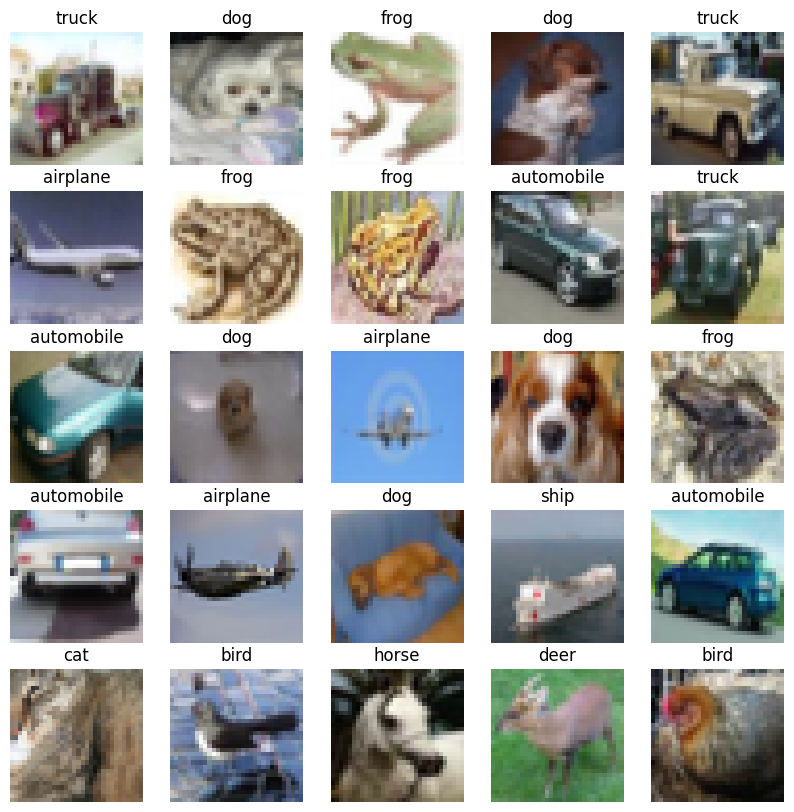

In [ ]:
# Para mostrar imágenes individuales, mejor tomar antes de hacer batch
datos_viz = datos_entrenamiento.unbatch().take(25)

plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_viz):
  plt.subplot(5,5,i+1)
  plt.imshow(imagen.numpy())
  plt.title(nombres_clases[etiqueta.numpy()])
  plt.axis("off")
plt.show()

In [ ]:
# Definir modelo CNN
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenar modelo
modelo.fit(
    datos_entrenamiento,
    epochs=15,
    validation_data=datos_pruebas
)



Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 53ms/step - accuracy: 0.3344 - loss: 1.7920 - val_accuracy: 0.5419 - val_loss: 1.2753
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 48ms/step - accuracy: 0.5774 - loss: 1.2011 - val_accuracy: 0.6294 - val_loss: 1.0467
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.6412 - loss: 1.0227 - val_accuracy: 0.6247 - val_loss: 1.0777
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.6843 - loss: 0.8949 - val_accuracy: 0.6611 - val_loss: 0.9712
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.7155 - loss: 0.8157 - val_accuracy: 0.6751 - val_loss: 0.9250
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7433 - loss: 0.7424 - val_accuracy: 0.7000 - val_loss: 0.8611
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - accuracy: 0.7638 - loss: 0.6771 - val_accuracy: 0.6942 - val_loss: 0.8894
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.7835 

In [ ]:
# Evaluación visual con predicciones
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)
  etiqueta_prediccion = np.argmax(arr_predicciones)
  color = "blue" if etiqueta_prediccion == etiqueta_real else "red"
  plt.xlabel("{} {:2.0f}% ({})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombres_clases[etiqueta_real]
  ), color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)
  grafica[etiqueta_prediccion].set_color("red")
  grafica[etiqueta_real].set_color("blue")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


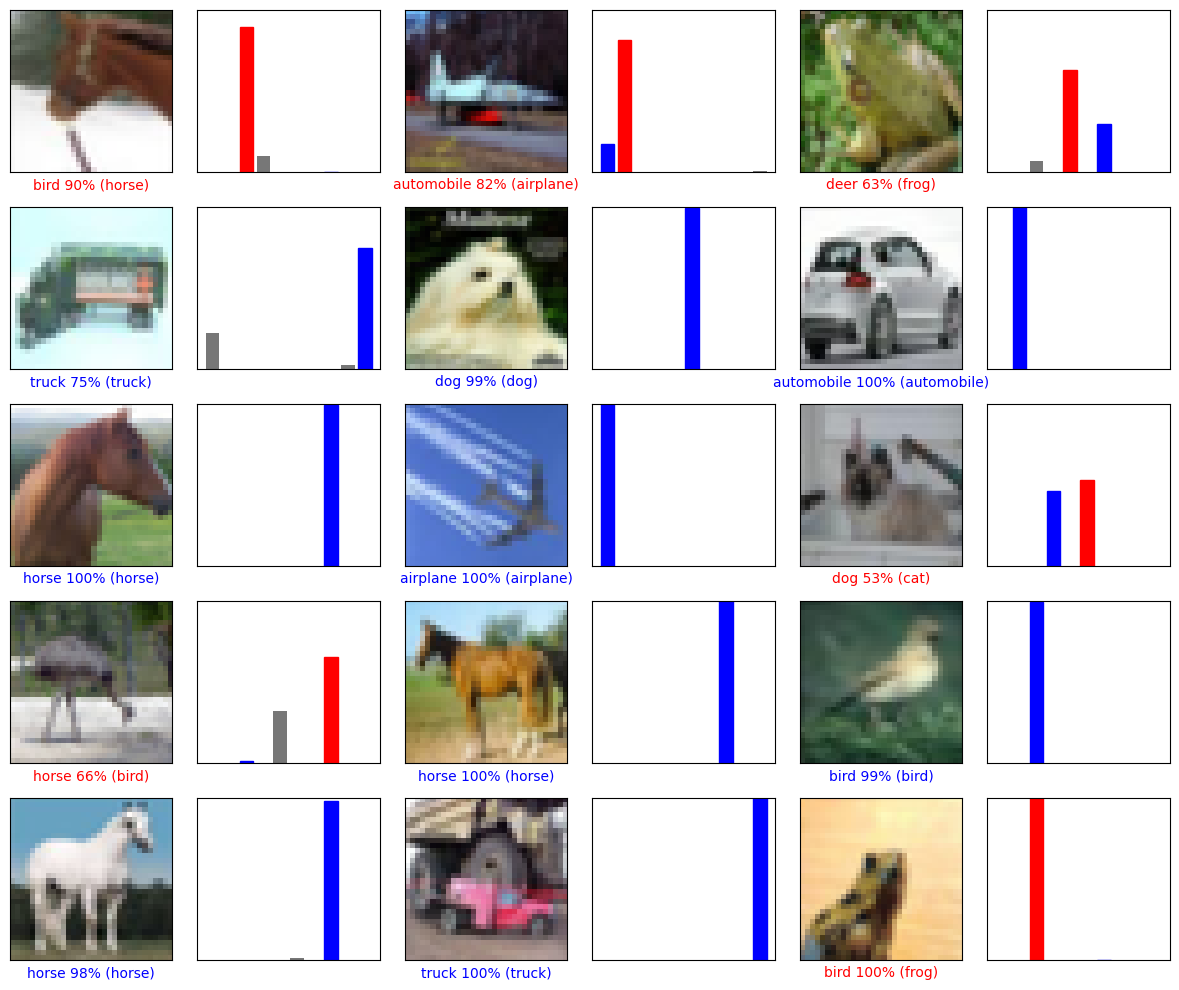

In [ ]:
# Mostrar 15 imágenes con predicción
filas, columnas = 5, 3
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(filas * columnas):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
plt.tight_layout()
plt.show()
